# Protocollo di 4 ore

Template utile per effettuare una competizione lampo di quattro ore. Si assume che il progetto sia non strutturato, cioè che tutti i file siano in un'unica directory. L'obbiettivo è quello di effettuare analisi esplorativa, training, validation e prediction in questo unico file. La filosofia di questo progetto è quindi quella di definire tutte le variabili temporanee dentro ai metodi in modo che vadano subito distrutte oppure di rimuoverle manualmente non appena non siano più necessarie.

## Funzioni

## Sezioni

* **[Analisi Esplorativa](#Analisi-Esplorativa)**
    * [Input da disco](#Input-da-disco)
    * [Studio dell'ID](#Studio-dell'ID)
    * [Missing data, presa visione](#Missing-data,-presa-visione)
    * [Concatenazione dei dataset](#Concatenazione-dei-dataset)
    * [Analisi dei tipi](#Analisi-dei-tipi)
    * [Analisi variabili numeriche](#Analisi-variabili-numeriche)
    * [Analisi variabili categoriche](#Analisi-variabili-categoriche)
    * [Imputazione missing data](#Imputazione-missing-data)
    * [Analisi del target](#Analisi-del-target)
    * [Scissione dei dataset](#Scissione-dei-dataset)
* **[Modello e submission](#Modello-e-submission)**
    * [SkLearn RandomForest con GridSearchCV](#SkLearn-RandomForest-con-GridSearchCV)

In [ ]:
#pacchetti generici necessari
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from IPython.display import display
import matplotlib.pyplot as plt 
import seaborn as sns
import gc
import time


%matplotlib inline

In [3]:
#funzione per l'input da disco
def read_file(filename):
    return pd.read_table(filename)

In [4]:
def columns_integrity_report(df_train, df_test):
    
    train_cols = df_train.columns.values.tolist()
    
    print('Train columns:\n')
    display(train_cols)
    
    test_cols = df_test.columns.values.tolist()
    
    print('Test columns:\n')
    display(test_cols)
    
    train_only = list(set(train_cols).difference(set(test_cols)))
    
    print('Train only columns:\n')
    display(train_only)
    
    test_only = list(set(test_cols).difference(set(train_cols)))
    
    print('Test only columns:\n')
    display(test_only)
    
    total_col = list(set(train_cols).union(set(test_cols)))
    
    n_total = len(total_col)
    n_train = len(train_cols)
    n_test = len(test_cols)
    n_train_only = len(train_only)
    n_test_only = len(test_only)
    
    print('Total columns:  {}\n'.format(n_total))
    print('Train columns:  {}\n'.format(n_train))
    print('Test columns:   {}\n'.format(n_test))
    print('Train only:     {}\n'.format(n_train_only))
    print('Test only:      {}\n'.format(n_test_only))    

In [5]:
#report sui missing data
def missing_data_report(df, drop=None):
    if drop is not None:
        df = df.drop(columns=drop)
        
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count())
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data.sort_values(by='Total', ascending=False)
    
    return missing_data

In [6]:
#concat train e test dopprando tipicamente il target e aggiungendo colonna bool che indica il test
def concat_dropping(df_train, df_test, to_drop):
    return pd.concat([df_train.drop(columns=to_drop), df_test.drop(columns=to_drop)],
                     axis=0,
                     names=['_test'],
                     keys = [False, True]).reset_index()

In [7]:
def describe_by_types(df):
    
    dtypes = df.drop(columns='_test').get_dtype_counts().index.values

    is_test = df['_test']==True
    
    for dtype in dtypes:
        print('\nReport of columns dtype: {}'.format(dtype))
        
        df_type = df.select_dtypes(include=[dtype])
        display(df_type.head())
        
        total = df_type.describe()
        train = df_type[~is_test].describe()
        test = df_type[is_test].describe()
        
        display(total)
        
        report = pd.concat([total, train, test], axis=1, keys=['Total', 'Train', 'Test'])\
                    .swaplevel(0,1, axis=1)\
                    .sort_index(axis=1, level=0)
        display(report)

In [8]:
def pca_analysis(df, target, mode):
    
    n_componets = df.shape[1]
    
    pca = PCA(n_components=n_componets)
    pipeline = Pipeline([('scaling', StandardScaler()), ('pca', pca)])
    
    pca_decomp = pipeline.fit_transform(df)
    
    data = pca_decomp[:,:2]
    
    print('Explained variance ratio:\n')
    print(pca.explained_variance_ratio_)
    
    data = data[target.index]
    
    if mode == 'regression':
        cmap = sns.cubehelix_palette(as_cmap=True)
        fig, ax = plt.subplots(figsize=(10,6))

        points = ax.scatter(data[:,0], data[:,1], c=target, s=0.005, cmap=cmap)
        fig.colorbar(points)

        plt.show()
        
    if mode == 'classification':
        
        data = pd.DataFrame({'x': data[:,0], 'y':data[:,1], 'z':target})
        sns.lmplot(x='x',y='y', data=data, fit_reg=False, 
                   hue='z', legend=True,scatter_kws={'s':10} )
        

In [13]:
def category_report(df, treshold, dropna=True):
    
    is_test = df['test']==True
    
    df_cat = df.select_dtypes(include=['category'])
    
    cat_feat = df_cat.columns.values.tolist()
    
    vc = {}
    vc_train = {}
    vc_test = {}
    
    n_values = {}
    n_train_values = {}
    n_test_values = {}
    
    for name in cat_feat:
        
        if dropna:
            col = df_cat[name].dropna()
            col_train = df_cat[name][~is_test].dropna()
            col_test = df_cat[name][is_test].dropna()
        else:
            col = df_cat[name]
            col_train = col[~is_test]
            col_test = col[is_test]
            
        
        _vc = col.value_counts().describe()
        _vc_train = col_train.value_counts().describe()
        _vc_test = col_test.value_counts().describe()
        
        vc[name] = _vc
        vc_train[name] = _vc_train
        vc_test[name] = _vc_test
        
        train_values = set(col_train.unique())
        test_values = set(col_test.unique())
        
        _n_values = _vc.shape[0]
        _n_train_values = len(list(train_values.difference(test_values)))
        _n_test_values = len(list(test_values.difference(train_values)))
        
        n_values[name] = _n_values
        n_train_values[name] = _n_train_values  
        n_test_values[name] = _n_test_values
        
    vc = pd.DataFrame(vc)
    vc_train = pd.DataFrame(vc_train)
    vc_test = pd.DataFrame(vc_test)
    
    report = pd.concat([vc, vc_train, vc_test], axis=1, keys=['Total', 'Train', 'Test'])\
                    .swaplevel(0,1, axis=1)\
                    .sort_index(axis=1, level=0)
    display(report)
    
    
        
    report = pd.DataFrame({'All':n_values, 'Train only':n_train_values, 'Test only':n_test_values})
    report.insert(1, 'Exclusive', report['Train only'] + report['Test only'])
    report = report.sort_values(by='Exclusive', ascending=False)
    
    display(report.head(10))
        
    lost = {}
    lost_1 = {}
    lost_2 = {}
    
    for name in cat_feat:
        
        if dropna:
            col = df_cat[name].dropna()
            col_train = df_cat[name][~is_test].dropna()
            col_test = df_cat[name][is_test].dropna()
        else:
            col = df_cat[name]
            col_train = col[~is_test]
            col_test = col[is_test]
        
        criteria_1 = ~col.isin(col_test.unique())
        criteria_2 = ~col.isin((col_train.value_counts() >= treshold).index)
        
        lost_1[name]=criteria_1.sum()
        lost_2[name]=criteria_2.sum()
        
        criteria = criteria_1 | criteria_2
        
        lost[name]=criteria.sum()
        
    report = pd.DataFrame({'crit':lost, 'crit1':lost_1, 'crit2':lost_2})
    report.insert(0,'crit %', report['crit']/len(df))
    report = report.sort_values(by='crit', ascending=False)
    
    display(report.head(10))

In [13]:
def cat_feat_integrity(df, treshold, crit1=True, crit2=True):
    
    is_test = df['test']==True
    
    df_cat = df.select_dtypes(include=['category'])
    
    cat_feat = df_cat.columns.values.tolist()
    
    lost = {}
    
    if crit1:
        lost_1 = {}
    if crit2:
        lost_2 = {}
    
    def to_apply(col):
        
        name = col.name
        
        col_train = col[~is_test]
        col_test = col[is_test]
        
        if crit1:
            criteria_1 = ~col.isin(col_test.unique())
        if crit2:
            criteria_2 = ~col.isin((col_train.value_counts() >= treshold).index)
        
        if crit1:
            lost_1[name]=criteria_1.sum()
        if crit2:
            lost_2[name]=criteria_2.sum()
        
        if crit1 and crit2:
            criteria = criteria_1 | criteria_2
        elif crit1:
            criteria = criteria_1
        else:
            criteria = criteria_2
        
        lost[name]=criteria.sum()
        
        tmp = col.astype('object')
        tmp[criteria] = '_artifact'
        
        return tmp.astype('category')
    
    df[cat_feat] = df_cat.apply(to_apply)
    
    d_dict = {'lost':lost}
    
    if crit1:
        d_dict['lost_1']=lost_1
    if crit2:
        d_dict['lost_2']=lost_2
    
    report = pd.DataFrame(d_dict)
    report.insert(0,'lost %', report['lost']/len(df))
    
    report = report.sort_values(by='lost', ascending=False)
    
    display(report.head(10))    

In [14]:
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to a tidy
    pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

In [15]:
def make_submission(y_pred, idx, model_name):
    
    filename = model_name + '_sumbimission.txt'
    
    y_pred = pd.Series(y_pred)
    y_pred.to_csv(filename, index=False)

# Analisi Esplorativa

In questa parte andremo ad effettuare l'analisi esplorativa e il preprocessing dei dati.

## Input da disco

Si assume che i file siano nella stessa directory di questo notebook, è necessario configurare i nomi dei file in **train_filename** e **test_filename** qui sotto e adattare la funzione **read_file** per il caso ad hoc. 

Il template prevede: 
* Leggere i file tramite **read_file**
* Mostrare sia per il train che per il test il metodo **head** e quello **info**
* Invocare la funzione definita dall'utente **columns_integrity_report** che mostra i nomi delle colonne tra train e test e controlla se vi siano colonne diverse tra train e test. Questo metodo serve principalmente per capire come sono date le colonne ID (solo su test o per entrambi?) e TARGET (solo sul train o anche sul test con NaN?)

In [16]:
#inserire max_columns tale da mostrare tutte le colonne se si vuole
pd.set_option('max_columns', 31, 'max_rows', 10)

In [17]:
train_filename = 'TRAIN.txt'
test_filename = 'TEST0.txt'

In [22]:
df_train = read_file(train_filename)
df_train.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>CASEID</th>
      <th>TARGET</th>
      <th>TKT_START</th>
      <th>MERCATO</th>
      <th>DEA</th>
      <th>COD_PR</th>
      <th>MCALL</th>
      <th>TKT_TYPE</th>
      <th>GRAVITA</th>
      <th>DINTERV</th>
      <th>MARCA</th>
      <th>MODELLO</th>
      <th>VERSIONE</th>
      <th>SERIE</th>
      <th>AVARROLE</th>
      <th>AVARUSER</th>
      <th>Apertura</th>
      <th>Assegnato</th>
      <th>Attesa_Ricambi</th>
      <th>Attesa_di_Conferma</th>
      <th>Attivazione_Specialista</th>
      <th>Caso_Riaperto</th>
      <th>Caso_Singolo</th>
      <th>Cet</th>
      <th>Confirmed</th>
      <th>Escalation</th>
      <th>Feedback_Negativo</th>
      <th>Prima_Attivazione_Secondo_Livello</th>
      <th>Riapertura</th>
      <th>Secondo_Livello_in_Uscita</th>
      <th>Soluzione_Non_Efficace</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>453.21</td>
      <td>0.00</td>
      <td>OTHER</td>
      <td>D00016</td>
      <td>OFFIC</td>
      <td>TKTREQcA10</td>
      <td>typeTESEO</td>
      <td>ALTA</td>
      <td>iCOMPLEX</td>
      <td>FIAT</td>
      <td>mod225</td>
      <td>ser1D2</td>
      <td>ser0</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0020</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>128.63</td>
      <td>17.82</td>
      <td>EUROPE</td>
      <td>D03014</td>
      <td>CONCESS</td>
      <td>TKTREQcA4</td>
      <td>typeTESEO</td>
      <td>ALTA</td>
      <td>iCOMPLEX</td>
      <td>CHRYSLER</td>
      <td>mod452</td>
      <td>serI10</td>
      <td>ser1</td>
      <td>DEA&amp;LV1&amp;LV2</td>
      <td>U0151 U0000 U0020</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>3</td>
      <td>0.42</td>
      <td>18.23</td>
      <td>SUDAFRICA</td>
      <td>D00130</td>
      <td>CONCESS</td>
      <td>TKTREQcC2</td>
      <td>typeTESEO</td>
      <td>NaN</td>
      <td>iEASY</td>
      <td>FIAT</td>
      <td>modKK0</td>
      <td>ser000</td>
      <td>ser0</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0064</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>4</td>
      <td>440.45</td>
      <td>18.54</td>
      <td>GERMANIA</td>
      <td>D01187</td>
      <td>OFFIC</td>
      <td>TKTREQcA10</td>
      <td>typeTESEO</td>
      <td>NaN</td>
      <td>iCOMPLEX</td>
      <td>JEEP</td>
      <td>mod604</td>
      <td>ser168</td>
      <td>ser8</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0008</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>5</td>
      <td>150.34</td>
      <td>18.56</td>
      <td>SUDAFRICA</td>
      <td>D00051</td>
      <td>CONCESS</td>
      <td>TKTREQcA10</td>
      <td>type

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80825 entries, 0 to 80824
Data columns (total 31 columns):
CASEID                               80825 non-null int64
TARGET                               80825 non-null float64
TKT_START                            80825 non-null float64
MERCATO                              80825 non-null object
DEA                                  80825 non-null object
COD_PR                               80825 non-null object
MCALL                                80825 non-null object
TKT_TYPE                             80825 non-null object
GRAVITA                              43603 non-null object
DINTERV                              80674 non-null object
MARCA                                80406 non-null object
MODELLO                              80825 non-null object
VERSIONE                             80825 non-null object
SERIE                                80825 non-null object
AVARROLE                             80825 non-null object
AVARU

In [30]:
df_test = read_file(test_filename)
df_test.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>CASEID</th>
      <th>TARGET</th>
      <th>TKT_START</th>
      <th>MERCATO</th>
      <th>DEA</th>
      <th>COD_PR</th>
      <th>MCALL</th>
      <th>TKT_TYPE</th>
      <th>GRAVITA</th>
      <th>DINTERV</th>
      <th>MARCA</th>
      <th>MODELLO</th>
      <th>VERSIONE</th>
      <th>SERIE</th>
      <th>AVARROLE</th>
      <th>AVARUSER</th>
      <th>Apertura</th>
      <th>Assegnato</th>
      <th>Attesa_Ricambi</th>
      <th>Attesa_di_Conferma</th>
      <th>Attivazione_Specialista</th>
      <th>Caso_Riaperto</th>
      <th>Caso_Singolo</th>
      <th>Cet</th>
      <th>Confirmed</th>
      <th>Escalation</th>
      <th>Feedback_Negativo</th>
      <th>Prima_Attivazione_Secondo_Livello</th>
      <th>Riapertura</th>
      <th>Secondo_Livello_in_Uscita</th>
      <th>Soluzione_Non_Efficace</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>80826</td>
      <td>NaN</td>
      <td>5046.51</td>
      <td>BRASILE</td>
      <td>D01416</td>
      <td>CONCESS</td>
      <td>TKTREQcA10</td>
      <td>typeTESEO</td>
      <td>ALTA</td>
      <td>iCOMPLEX</td>
      <td>FIAT</td>
      <td>mod245</td>
      <td>serG34</td>
      <td>ser0</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0003</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>80827</td>
      <td>NaN</td>
      <td>5046.61</td>
      <td>BRASILE</td>
      <td>D00201</td>
      <td>CONCESS</td>
      <td>TKTREQcA10</td>
      <td>typeTESEO</td>
      <td>NaN</td>
      <td>iCOMPLEX</td>
      <td>FIAT</td>
      <td>mod197</td>
      <td>ser163</td>
      <td>ser0</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0002</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>80828</td>
      <td>NaN</td>
      <td>5046.62</td>
      <td>ARGENTINA</td>
      <td>D00005</td>
      <td>CONCESS</td>
      <td>TKTREQcC1</td>
      <td>typeTESEO</td>
      <td>NaN</td>
      <td>iEASY</td>
      <td>FIAT</td>
      <td>mod198</td>
      <td>ser5M8</td>
      <td>ser1</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0013</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>80829</td>
      <td>NaN</td>
      <td>5046.72</td>
      <td>BRASILE</td>
      <td>D05792</td>
      <td>CONCESS</td>
      <td>TKTREQcA10</td>
      <td>typeTESEO</td>
      <td>ALTA</td>
      <td>iCOMPLEX</td>
      <td>FIAT</td>
      <td>mod197</td>
      <td>ser163</td>
      <td>ser0</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0002</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>80830</td>
      <td>NaN</td>
      <td>5046.74</td>
      <td>BRASILE</td>
      <td>D00124</td>
      <td>CONCESS</td>
      <td>TKTREQcA10</td>
      <td

In [30]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34639 entries, 0 to 34638
Data columns (total 31 columns):
CASEID                               34639 non-null int64
TARGET                               0 non-null float64
TKT_START                            34639 non-null float64
MERCATO                              34639 non-null object
DEA                                  34639 non-null object
COD_PR                               34639 non-null object
MCALL                                34639 non-null object
TKT_TYPE                             34639 non-null object
GRAVITA                              17869 non-null object
DINTERV                              34468 non-null object
MARCA                                34446 non-null object
MODELLO                              34639 non-null object
VERSIONE                             34639 non-null object
SERIE                                34639 non-null object
AVARROLE                             34639 non-null object
AVARUSER 

In [1]:
columns_integrity_report(df_train, df_test)

## Missing data, presa visione

Questa sezione serve a prendere coscienza inizialmente dei missing data, prevede:
* Lanciare la funzione definita dall'utente **missing_data_report** che conta i missing data e ritorna il numero totale e la percentuale di missing data per ogni colonna ordinati in modo discendente.

In [32]:
pd.set_option('max_columns', 31, 'max_rows', 10)

In [37]:
missing_data = missing_data_report(df_train)
missing_data.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Total</th>
      <th>Percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>GRAVITA</th>
      <td>37222</td>
      <td>0.460526</td>
    </tr>
    <tr>
      <th>MARCA</th>
      <td>419</td>
      <td>0.005184</td>
    </tr>
    <tr>
      <th>DINTERV</th>
      <td>151</td>
      <td>0.001868</td>
    </tr>
    <tr>
      <th>Attesa_di_Conferma</th>
      <td>0</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>Attivazione_Specialista</th>
      <td>0</td>
      <td>0.000000</td>
    </tr>
  </tbody>
</table>
</div>

In [41]:
missing_data = missing_data_report(df_test)
missing_data.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Total</th>
      <th>Percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>TARGET</th>
      <td>34639</td>
      <td>1.000000</td>
    </tr>
    <tr>
      <th>GRAVITA</th>
      <td>16770</td>
      <td>0.484136</td>
    </tr>
    <tr>
      <th>MARCA</th>
      <td>193</td>
      <td>0.005572</td>
    </tr>
    <tr>
      <th>DINTERV</th>
      <td>171</td>
      <td>0.004937</td>
    </tr>
    <tr>
      <th>Attivazione_Specialista</th>
      <td>0</td>
      <td>0.000000</td>
    </tr>
  </tbody>
</table>
</div>

In [41]:
del missing_data
gc.collect()

127

## Studio dell'ID

Tipicamente i dataset vengono forniti con un ID di riga necessario per identificare le previsioni nella submission. A volte questo ID può non essere presente nel train, altre si. L'ID dovrebbe essere dato a caso ma a volte, se presente nel train, è significativo. Questa sezione si preclude l'obbiettivo di capire come si presenta l'ID e, qualora sia presente nel train, di effettuare un test per decidere subito se scartarlo o meno come predittore.

Prevede:
* ...parte ad hoc implementata dall'utente...

**Parte ad hoc**

Di seguito parte ad hoc per l'esempio busisness game 2017

In [42]:
id_col = 'CASEID'

In [43]:
#controlliamo che l'ID sia unico
df_train.shape[0]

80825

In [44]:
np.size(df_train[id_col].unique())

80825

In [45]:
df_test.shape[0]

34639

In [46]:
np.size(df_test[id_col].unique())

34639

In [47]:
df_train[id_col].describe()

count    80825.000000
mean     40413.000000
std      23332.312091
min          1.000000
25%      20207.000000
50%      40413.000000
75%      60619.000000
max      80825.000000
Name: CASEID, dtype: float64

In [48]:
df_test[id_col].describe()

count     34639.000000
mean      98145.000000
std        9999.562324
min       80826.000000
25%       89485.500000
50%       98145.000000
75%      106804.500000
max      115464.000000
Name: CASEID, dtype: float64

In questo caso non è necessaria alcun analisi, gli ID son completamente diversi tra train e test quindi sicuramente non è una features utile.

In [49]:
del id_col
gc.collect()

0

## Concatenazione dei dataset

In questa sezione si uniscono i dataset per effettuare analisi su di entrambi. Il test e il train rimangono in memoria per successivi utilizzi, si assume di lavorare con dataset abbastanza piccoli da permettere un uso grossolano della memoria.

Questa sezione prevede:
* Concatenare il train e il test tramite **concat_dropping** che permette, specificando tramite il parametro **to_drop** una colonna o una lista di colonne, di droppare e quindi escludere dalle successive analisi alcune colonne (tipicamente ID e TARGET). La funzione **concat_dropping** inoltre aggiunge una colonna di bool al dataset completo per specificare quali esempi fanno parte del test, questa colonna è necessaria implicitamente a molte altre funzioni definite dall'utente e anche in questo caso costituisce una soluzione grossolana.
* Mostrare il metodo **head** sul database complessivo.

In [50]:
pd.set_option('max_columns', 33, 'max_rows', 10)

In [51]:
target_name = 'TARGET'
id_name = 'CASEID'

In [52]:
#salviamo la colonna target per il futuro
target = df_train.set_index(id_name)[target_name]

In [55]:
df = concat_dropping(df_train, df_test, to_drop=[target_name]).set_index(id_name).sort_index()
df.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>_test</th>
      <th>level_1</th>
      <th>TKT_START</th>
      <th>MERCATO</th>
      <th>DEA</th>
      <th>COD_PR</th>
      <th>MCALL</th>
      <th>TKT_TYPE</th>
      <th>GRAVITA</th>
      <th>DINTERV</th>
      <th>MARCA</th>
      <th>MODELLO</th>
      <th>VERSIONE</th>
      <th>SERIE</th>
      <th>AVARROLE</th>
      <th>AVARUSER</th>
      <th>Apertura</th>
      <th>Assegnato</th>
      <th>Attesa_Ricambi</th>
      <th>Attesa_di_Conferma</th>
      <th>Attivazione_Specialista</th>
      <th>Caso_Riaperto</th>
      <th>Caso_Singolo</th>
      <th>Cet</th>
      <th>Confirmed</th>
      <th>Escalation</th>
      <th>Feedback_Negativo</th>
      <th>Prima_Attivazione_Secondo_Livello</th>
      <th>Riapertura</th>
      <th>Secondo_Livello_in_Uscita</th>
      <th>Soluzione_Non_Efficace</th>
    </tr>
    <tr>
      <th>CASEID</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>False</td>
      <td>0</td>
      <td>0.00</td>
      <td>OTHER</td>
      <td>D00016</td>
      <td>OFFIC</td>
      <td>TKTREQcA10</td>
      <td>typeTESEO</td>
      <td>ALTA</td>
      <td>iCOMPLEX</td>
      <td>FIAT</td>
      <td>mod225</td>
      <td>ser1D2</td>
      <td>ser0</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0020</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>False</td>
      <td>1</td>
      <td>17.82</td>
      <td>EUROPE</td>
      <td>D03014</td>
      <td>CONCESS</td>
      <td>TKTREQcA4</td>
      <td>typeTESEO</td>
      <td>ALTA</td>
      <td>iCOMPLEX</td>
      <td>CHRYSLER</td>
      <td>mod452</td>
      <td>serI10</td>
      <td>ser1</td>
      <td>DEA&amp;LV1&amp;LV2</td>
      <td>U0151 U0000 U0020</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>False</td>
      <td>2</td>
      <td>18.23</td>
      <td>SUDAFRICA</td>
      <td>D00130</td>
      <td>CONCESS</td>
      <td>TKTREQcC2</td>
      <td>typeTESEO</td>
      <td>NaN</td>
      <td>iEASY</td>
      <td>FIAT</td>
      <td>modKK0</td>
      <td>ser000</td>
      <td>ser0</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0064</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>False</td>
      <td>3</td>
      <td>18.54</td>
      <td>GERMANIA</td>
      <td>D01187</td>
      <td>OFFIC</td>
      <td>TKTREQcA10</td>
      <td>typeTESEO</td>
      <td>NaN</td>
      <td>iCOMPLEX</td>
      <td>JEEP</td>
      <td>mod604</td>
      <td>ser168</td>


In [55]:
del df_train
del df_test
del target_name
del id_name
gc.collect()

655

## Analisi dei tipi

In questa sezione ci si preoccupa di assegnagare il corretto **dtype** ad ogni colonna, di fare parsing delle date etc. In particolare le successive analisi assumono che ogni variabile numerica sia di tipo float o int e che ogni variabile di tipo categorico sia di tipo pd.Categorical, ottenibile tramite **pd.Series.astype('category')**. Purtroppo questa parte dipende strettamente dal problema ed è richiesto all'utente di implementare una soluzione ad hoc avvalendosi anche della documentazione fornita con il database.

Prevede:
* Mostrare i tipi con cui le variabili si presentano e il loro conteggio.
* Mostrare il numero di valori diversi assumibili per ogni variabile.
* Lancia la funzione definita dall'utente **describe_by_types** che mostra il metodo **describe** su ogni gruppo di variabili prima solo per il totale e poi per totale, test e train.
* ...metodi ad hoc che l'utente deve implementare per portare le variabili nel tipo corretto...

**NOTA:** ricordarsi che la presenza di NaN trasforma ogni variabile numerica in float (mentre non lo fa per quelle object e pd.Categorical), perciò il numero di variabili float potrebbe essere falsato.

In [56]:
pd.set_option('max_columns', 33, 'max_rows', 10)

In [57]:
with pd.option_context('display.max_rows', 35):
    display(df.drop(columns='_test').dtypes)

level_1                                int64
TKT_START                            float64
MERCATO                               object
DEA                                   object
COD_PR                                object
MCALL                                 object
TKT_TYPE                              object
GRAVITA                               object
DINTERV                               object
MARCA                                 object
MODELLO                               object
VERSIONE                              object
SERIE                                 object
AVARROLE                              object
AVARUSER                              object
Apertura                               int64
Assegnato                              int64
Attesa_Ricambi                         int64
Attesa_di_Conferma                     int64
Attivazione_Specialista                int64
Caso_Riaperto                          int64
Caso_Singolo                           int64
Cet       

In [58]:
df.drop(columns='_test').get_dtype_counts()

float64     1
int64      16
object     13
dtype: int64

In [63]:
#inserire max_rows uguale o maggiore del numero di colonne per vederle tutte
with pd.option_context('display.max_rows', 35):
    display(df.drop(columns='_test').nunique().sort_values())

Soluzione_Non_Efficace                   2
Riapertura                               2
Prima_Attivazione_Secondo_Livello        2
Cet                                      2
Caso_Singolo                             2
Caso_Riaperto                            2
Attivazione_Specialista                  2
Attesa_Ricambi                           2
Escalation                               2
AVARROLE                                 2
Secondo_Livello_in_Uscita                2
Confirmed                                3
Attesa_di_Conferma                       3
Assegnato                                3
Apertura                                 3
Feedback_Negativo                        3
DINTERV                                  3
GRAVITA                                  3
TKT_TYPE                                 4
MARCA                                    7
COD_PR                                  11
MCALL                                   16
SERIE                                   19
MERCATO    

In [66]:
describe_by_types(df)


Report of columns dtype: float64


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>TKT_START</th>
    </tr>
    <tr>
      <th>CASEID</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>0.00</td>
    </tr>
    <tr>
      <th>2</th>
      <td>17.82</td>
    </tr>
    <tr>
      <th>3</th>
      <td>18.23</td>
    </tr>
    <tr>
      <th>4</th>
      <td>18.54</td>
    </tr>
    <tr>
      <th>5</th>
      <td>18.56</td>
    </tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>TKT_START</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>115464.000000</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>3648.405859</td>
    </tr>
    <tr>
      <th>std</th>
      <td>2145.888346</td>
    </tr>
    <tr>
      <th>min</th>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>25%</th>
      <td>1733.640000</td>
    </tr>
    <tr>
      <th>50%</th>
      <td>3649.985000</td>
    </tr>
    <tr>
      <th>75%</th>
      <td>5523.845000</td>
    </tr>
    <tr>
      <th>max</th>
      <td>7578.100000</td>
    </tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead tr th {
        text-align: left;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="3" halign="left">TKT_START</th>
    </tr>
    <tr>
      <th></th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>34639.000000</td>
      <td>115464.000000</td>
      <td>80825.000000</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>6277.321333</td>
      <td>3648.405859</td>
      <td>2521.737091</td>
    </tr>
    <tr>
      <th>std</th>
      <td>674.517956</td>
      <td>2145.888346</td>
      <td>1466.973196</td>
    </tr>
    <tr>
      <th>min</th>
      <td>5046.510000</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>25%</th>
      <td>5731.510000</td>
      <td>1733.640000</td>
      <td>1201.900000</td>
    </tr>
    <tr>
      <th>50%</th>
      <td>6261.380000</td>
      <td>3649.985000</td>
      <td>2473.860000</td>
    </tr>
    <tr>
      <th>75%</th>
      <td>6846.280000</td>
      <td>5523.845000</td>
      <td>3818.260000</td>
    </tr>
    <tr>
      <th>max</th>
      <td>7578.100000</td>
      <td>7578.100000</td>
      <td>5046.480000</td>
    </tr>
  </tbody>
</table>
</div>


Report of columns dtype: int64


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>level_1</th>
      <th>Apertura</th>
      <th>Assegnato</th>
      <th>Attesa_Ricambi</th>
      <th>Attesa_di_Conferma</th>
      <th>Attivazione_Specialista</th>
      <th>Caso_Riaperto</th>
      <th>Caso_Singolo</th>
      <th>Cet</th>
      <th>Confirmed</th>
      <th>Escalation</th>
      <th>Feedback_Negativo</th>
      <th>Prima_Attivazione_Secondo_Livello</th>
      <th>Riapertura</th>
      <th>Secondo_Livello_in_Uscita</th>
      <th>Soluzione_Non_Efficace</th>
    </tr>
    <tr>
      <th>CASEID</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>0</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>5</th>
      <td>4</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>level_1</th>
      <th>Apertura</th>
      <th>Assegnato</th>
      <th>Attesa_Ricambi</th>
      <th>Attesa_di_Conferma</th>
      <th>Attivazione_Specialista</th>
      <th>Caso_Riaperto</th>
      <th>Caso_Singolo</th>
      <th>Cet</th>
      <th>Confirmed</th>
      <th>Escalation</th>
      <th>Feedback_Negativo</th>
      <th>Prima_Attivazione_Secondo_Livello</th>
      <th>Riapertura</th>
      <th>Secondo_Livello_in_Uscita</th>
      <th>Soluzione_Non_Efficace</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
      <td>115464.000000</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>33484.140000</td>
      <td>0.899579</td>
      <td>0.960698</td>
      <td>0.038809</td>
      <td>0.827331</td>
      <td>0.066202</td>
      <td>0.046534</td>
      <td>0.000199</td>
      <td>0.000580</td>
      <td>0.882595</td>
      <td>0.008947</td>
      <td>0.416502</td>
      <td>0.061032</td>
      <td>0.005552</td>
      <td>0.036522</td>
      <td>0.052068</td>
    </tr>
    <tr>
      <th>std</th>
      <td>22870.607143</td>
      <td>0.300648</td>
      <td>0.200414</td>
      <td>0.193139</td>
      <td>0.378077</td>
      <td>0.248637</td>
      <td>0.210639</td>
      <td>0.014112</td>
      <td>0.024082</td>
      <td>0.322038</td>
      <td>0.094162</td>
      <td>0.493051</td>
      <td>0.239390</td>
      <td>0.074302</td>
      <td>0.187586</td>
      <td>0.222166</td>
    </tr>
    <tr>
      <th>min</th>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>25%</th>
      <td>14432.750000</td>
      <td>1.000000</td>
      <td>1.000000</td>
      <td>0.000000</td>
      <td>1.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>1.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>50%</th>
      <td>28865.500000</td>
      <td>1.000000</td>
      <td>1.000000</td>
      <td>0.000000</td>
      <td>1.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>1.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>75%</th>
      <td>51958.250000</td>
      <td>1.000000</td>
      <td>1.000000</td>
      <td>0.000000</td>
      <td>1.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>1.000000</td>
      <td>0.000000</td>
      <td>1.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>max</th>
      <td>80824.000000</td>
      <td>2.000000</td>
      <td

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead tr th {
        text-align: left;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="3" halign="left">Apertura</th>
      <th colspan="3" halign="left">Assegnato</th>
      <th colspan="3" halign="left">Attesa_Ricambi</th>
      <th colspan="3" halign="left">Attesa_di_Conferma</th>
      <th colspan="3" halign="left">Attivazione_Specialista</th>
      <th>Caso_Riaperto</th>
      <th>...</th>
      <th>Feedback_Negativo</th>
      <th colspan="3" halign="left">Prima_Attivazione_Secondo_Livello</th>
      <th colspan="3" halign="left">Riapertura</th>
      <th colspan="3" halign="left">Secondo_Livello_in_Uscita</th>
      <th colspan="3" halign="left">Soluzione_Non_Efficace</th>
      <th colspan="3" halign="left">level_1</th>
    </tr>
    <tr>
      <th></th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>...</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>34639.000000</td>
      <td>115464.000000</td>
      <td>80825.000000</td>
      <td>34639.000000</td>
      <td>115464.000000</td>
      <td>80825.000000</td>
      <td>34639.000000</td>
      <td>115464.000000</td>
      <td>80825.000000</td>
      <td>34639.000000</td>
      <td>115464.000000</td>
      <td>80825.000000</td>
      <td>34639.000000</td>
      <td>115464.000000</td>
      <td>80825.000000</td>
      <td>34639.000000</td>
      <td>...</td>
      <td>80825.000000</td>
      <td>34639.000000</td>
      <td>115464.000000</td>
      <td>80825.000000</td>
      <td>34639.000000</td>
      <td>115464.000000</td>
      <td>80825.000000</td>
      <td>34639.000000</td>
      <td>115464.000000</td>
      <td>80825.000000</td>
      <td>34639.000000</td>
      <td>115464.000000</td>
      <td>80825.000000</td>
      <td>34639.000000</td>
      <td>115464.000000</td>
      <td>80825.000000</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>0.897659</td>
      <td>0.899579</td>
      <td>0.900402</td>
      <td>0.970582</td>
      <td>0.960698</td>
      <td>0.956461</td>
      <td>0.035884</td>
      <td>0.038809</td>
      <td>0.040062</td>
      <td>0.832472</td>
      <td>0.827331</td>
      <td>0.825128</td>
      <td>0.060510</td>
      <td>0.066202</td>
      <td>0.068642</td>
      <td>0.040821</td>
      <td>...</td>
      <td>0.422357</td>
      <td>0.055718</td>
      <td>0.061032</td>
      <td>0.063310</td>
      <td>0.004590</td>
      <td>0.005552</td>
      <td>0.005964</td>
      <td>0.030659</td>
      <td>0.036522</td>
      <td>0.039035</td>
      <td>0.045411</td>
      <td>0.052068</td>
      <td>0.054921</td>
      <td>17319.000000</td>
      <td>33484.140000</td>
      <td>40412.000000</td>
    </tr>
    <tr>
      <th>std</th>
      <td>0.303291</td>
      <td>0.300648</td>
      <td>0.299506</td>
      <td>0.177476</td>
      <td>0.200414</td>
      <td>0.209335</td>
      <td>0.186005</td>
      <td>0.193139</td>
      <td>0.196106</td>
      <td>0.373452</td>
      <td>0.378077</td>
      <td>0.380022</td>
      <td>0.238432</td>
      <td>0.248637</td>
      <td>0.252846</td>
      <td>0.197878</td>
      <td>...</td>
      <td>0.494038</td>
      <td>0.22937


Report of columns dtype: object


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>MERCATO</th>
      <th>DEA</th>
      <th>COD_PR</th>
      <th>MCALL</th>
      <th>TKT_TYPE</th>
      <th>GRAVITA</th>
      <th>DINTERV</th>
      <th>MARCA</th>
      <th>MODELLO</th>
      <th>VERSIONE</th>
      <th>SERIE</th>
      <th>AVARROLE</th>
      <th>AVARUSER</th>
    </tr>
    <tr>
      <th>CASEID</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>OTHER</td>
      <td>D00016</td>
      <td>OFFIC</td>
      <td>TKTREQcA10</td>
      <td>typeTESEO</td>
      <td>ALTA</td>
      <td>iCOMPLEX</td>
      <td>FIAT</td>
      <td>mod225</td>
      <td>ser1D2</td>
      <td>ser0</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0020</td>
    </tr>
    <tr>
      <th>2</th>
      <td>EUROPE</td>
      <td>D03014</td>
      <td>CONCESS</td>
      <td>TKTREQcA4</td>
      <td>typeTESEO</td>
      <td>ALTA</td>
      <td>iCOMPLEX</td>
      <td>CHRYSLER</td>
      <td>mod452</td>
      <td>serI10</td>
      <td>ser1</td>
      <td>DEA&amp;LV1&amp;LV2</td>
      <td>U0151 U0000 U0020</td>
    </tr>
    <tr>
      <th>3</th>
      <td>SUDAFRICA</td>
      <td>D00130</td>
      <td>CONCESS</td>
      <td>TKTREQcC2</td>
      <td>typeTESEO</td>
      <td>NaN</td>
      <td>iEASY</td>
      <td>FIAT</td>
      <td>modKK0</td>
      <td>ser000</td>
      <td>ser0</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0064</td>
    </tr>
    <tr>
      <th>4</th>
      <td>GERMANIA</td>
      <td>D01187</td>
      <td>OFFIC</td>
      <td>TKTREQcA10</td>
      <td>typeTESEO</td>
      <td>NaN</td>
      <td>iCOMPLEX</td>
      <td>JEEP</td>
      <td>mod604</td>
      <td>ser168</td>
      <td>ser8</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0008</td>
    </tr>
    <tr>
      <th>5</th>
      <td>SUDAFRICA</td>
      <td>D00051</td>
      <td>CONCESS</td>
      <td>TKTREQcA10</td>
      <td>typeTESEO</td>
      <td>MEDIA</td>
      <td>iCOMPLEX</td>
      <td>FIAT</td>
      <td>modJK0</td>
      <td>ser000</td>
      <td>ser0</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0064</td>
    </tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>MERCATO</th>
      <th>DEA</th>
      <th>COD_PR</th>
      <th>MCALL</th>
      <th>TKT_TYPE</th>
      <th>GRAVITA</th>
      <th>DINTERV</th>
      <th>MARCA</th>
      <th>MODELLO</th>
      <th>VERSIONE</th>
      <th>SERIE</th>
      <th>AVARROLE</th>
      <th>AVARUSER</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>115464</td>
      <td>115464</td>
      <td>115464</td>
      <td>115464</td>
      <td>115464</td>
      <td>61472</td>
      <td>115142</td>
      <td>114852</td>
      <td>115464</td>
      <td>115464</td>
      <td>115464</td>
      <td>115464</td>
      <td>115464</td>
    </tr>
    <tr>
      <th>unique</th>
      <td>20</td>
      <td>9029</td>
      <td>11</td>
      <td>16</td>
      <td>4</td>
      <td>3</td>
      <td>3</td>
      <td>7</td>
      <td>135</td>
      <td>1603</td>
      <td>19</td>
      <td>2</td>
      <td>2481</td>
    </tr>
    <tr>
      <th>top</th>
      <td>ITALIA</td>
      <td>D00002</td>
      <td>CONCESS</td>
      <td>TKTREQcA10</td>
      <td>typeTESEO</td>
      <td>ALTA</td>
      <td>iCOMPLEX</td>
      <td>FIAT</td>
      <td>mod604</td>
      <td>ser271</td>
      <td>ser0</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0001</td>
    </tr>
    <tr>
      <th>freq</th>
      <td>33327</td>
      <td>469</td>
      <td>92489</td>
      <td>87511</td>
      <td>105330</td>
      <td>39564</td>
      <td>80657</td>
      <td>81259</td>
      <td>7691</td>
      <td>3430</td>
      <td>58566</td>
      <td>104083</td>
      <td>6266</td>
    </tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead tr th {
        text-align: left;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="3" halign="left">AVARROLE</th>
      <th colspan="3" halign="left">AVARUSER</th>
      <th colspan="3" halign="left">COD_PR</th>
      <th colspan="3" halign="left">DEA</th>
      <th colspan="3" halign="left">DINTERV</th>
      <th>GRAVITA</th>
      <th>...</th>
      <th>MCALL</th>
      <th colspan="3" halign="left">MERCATO</th>
      <th colspan="3" halign="left">MODELLO</th>
      <th colspan="3" halign="left">SERIE</th>
      <th colspan="3" halign="left">TKT_TYPE</th>
      <th colspan="3" halign="left">VERSIONE</th>
    </tr>
    <tr>
      <th></th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>...</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
      <th>Test</th>
      <th>Total</th>
      <th>Train</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>34639</td>
      <td>115464</td>
      <td>80825</td>
      <td>34639</td>
      <td>115464</td>
      <td>80825</td>
      <td>34639</td>
      <td>115464</td>
      <td>80825</td>
      <td>34639</td>
      <td>115464</td>
      <td>80825</td>
      <td>34468</td>
      <td>115142</td>
      <td>80674</td>
      <td>17869</td>
      <td>...</td>
      <td>80825</td>
      <td>34639</td>
      <td>115464</td>
      <td>80825</td>
      <td>34639</td>
      <td>115464</td>
      <td>80825</td>
      <td>34639</td>
      <td>115464</td>
      <td>80825</td>
      <td>34639</td>
      <td>115464</td>
      <td>80825</td>
      <td>34639</td>
      <td>115464</td>
      <td>80825</td>
    </tr>
    <tr>
      <th>unique</th>
      <td>2</td>
      <td>2</td>
      <td>2</td>
      <td>1323</td>
      <td>2481</td>
      <td>2048</td>
      <td>10</td>
      <td>11</td>
      <td>11</td>
      <td>6277</td>
      <td>9029</td>
      <td>8038</td>
      <td>3</td>
      <td>3</td>
      <td>3</td>
      <td>3</td>
      <td>...</td>
      <td>16</td>
      <td>20</td>
      <td>20</td>
      <td>20</td>
      <td>134</td>
      <td>135</td>
      <td>135</td>
      <td>19</td>
      <td>19</td>
      <td>19</td>
      <td>4</td>
      <td>4</td>
      <td>4</td>
      <td>1549</td>
      <td>1603</td>
      <td>1603</td>
    </tr>
    <tr>
      <th>top</th>
      <td>DEA&amp;LV1</td>
      <td>DEA&amp;LV1</td>
      <td>DEA&amp;LV1</td>
      <td>U0000 U0001</td>
      <td>U0000 U0001</td>
      <td>U0000 U0001</td>
      <td>CONCESS</td>
      <td>CONCESS</td>
      <td>CONCESS</td>
      <td>D00013</td>
      <td>D00002</td>
      <td>D00002</td>
      <td>iCOMPLEX</td>
      <td>iCOMPLEX</td>
      <td>iCOMPLEX</td>
      <td>ALTA</td>
      <td>...</td>
      <td>TKTREQcA10</td>
      <td>ITALIA</td>
      <td>ITALIA</td>
      <td>ITALIA</td>
      <td>mod604</td>
      <td>mod604</td>
      <td>mod604</td>
      <td>ser0</td>
      <td>ser0</td>
      <td>ser0</td>
      <td>typeTESEO</td>
      <td>typeTESEO</td>
      <td>typeTESEO</td>
      <td>ser000</td>
      <td>ser271</td>
      <td>ser271</td>
    </tr>
    <tr>
      <th>freq</th>
      <td>31568</td>
      <td>104083</td>
      <td>72515</td>
      <td>1937</td>
      <td>6266</td>
      <td>4329</td>
      <td>28120</td>
      <td>92489</td>
      <

In [70]:
#trasformiamo in categoy tutte la colonne object e quelle binarie (con 2 valori)
columns1 = df.drop(columns='_test').dtypes[df.drop(columns='_test').dtypes == 'object'].index
columns2 = df.drop(columns='_test').nunique()[df.drop(columns='_test').nunique()==2].index
columns = list(set(columns1).union(set(columns2)))
columns

['MERCATO',
 'VERSIONE',
 'DEA',
 'MODELLO',
 'Caso_Riaperto',
 'Secondo_Livello_in_Uscita',
 'SERIE',
 'Attesa_Ricambi',
 'AVARUSER',
 'GRAVITA',
 'COD_PR',
 'MCALL',
 'DINTERV',
 'MARCA',
 'Escalation',
 'Attivazione_Specialista',
 'Prima_Attivazione_Secondo_Livello',
 'AVARROLE',
 'Cet',
 'Caso_Singolo',
 'Riapertura',
 'Soluzione_Non_Efficace',
 'TKT_TYPE']

In [71]:
del columns1
del columns2
gc.collect()

1347

In [72]:
df[columns] = df[columns].transform(lambda col: col.astype('category'))

In [73]:
df.drop(columns='_test').get_dtype_counts()

category    23
float64      1
int64        6
dtype: int64

In [74]:
del columns
gc.collect()

7

## Analisi variabili numeriche

Questa sezione si preclude di analizzare le variabili numeriche.

Prevede:
* Mostrare il numero di valori assumibili dalle variabili numeriche.
* Mostrare kurtosis di Fisher e skewness per ogni variabile numerica.
* Mostrare il metodo **describe** per le variabili numeriche.
* Heatmap delle correlazioni.
* Analisi PCA standardizzati, mostra il rapporto della varianza spiegata e il grafico in relazione al target dei primi due componenti.

**NOTA:** la skewness di una normale è 0, e anche la kurtsosi di Fisher per una normale è 0 (a differenza della comune definizione di kurtosi).

In [75]:
df_numeric = df.select_dtypes(include=['number'])
df_numeric.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>level_1</th>
      <th>TKT_START</th>
      <th>Apertura</th>
      <th>Assegnato</th>
      <th>Attesa_di_Conferma</th>
      <th>Confirmed</th>
      <th>Feedback_Negativo</th>
    </tr>
    <tr>
      <th>CASEID</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>0</td>
      <td>0.00</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1</td>
      <td>17.82</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2</td>
      <td>18.23</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>18.54</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>5</th>
      <td>4</td>
      <td>18.56</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

In [76]:
#inserire max_rows uguale o maggiore del numero di colonne per vederle tutte
with pd.option_context('display.max_rows', 35):
    display(df_numeric.nunique().sort_values())

Apertura                  3
Assegnato                 3
Attesa_di_Conferma        3
Confirmed                 3
Feedback_Negativo         3
level_1               80825
TKT_START             92328
dtype: int64

In [77]:
skew = lambda col: col.skew()
skew.__name__ = 'skew'
kurt = lambda col: col.kurtosis()
kurt.__name__ = 'kurt'

In [78]:
df_numeric.agg([skew, kurt]).T

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>skew</th>
      <th>kurt</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>level_1</th>
      <td>0.453995</td>
      <td>-0.961625</td>
    </tr>
    <tr>
      <th>TKT_START</th>
      <td>0.049469</td>
      <td>-1.203121</td>
    </tr>
    <tr>
      <th>Apertura</th>
      <td>-2.656060</td>
      <td>5.067457</td>
    </tr>
    <tr>
      <th>Assegnato</th>
      <td>-4.286684</td>
      <td>19.260716</td>
    </tr>
    <tr>
      <th>Attesa_di_Conferma</th>
      <td>-1.729712</td>
      <td>1.000395</td>
    </tr>
    <tr>
      <th>Confirmed</th>
      <td>-2.373235</td>
      <td>3.648404</td>
    </tr>
    <tr>
      <th>Feedback_Negativo</th>
      <td>0.339620</td>
      <td>-1.882347</td>
    </tr>
  </tbody>
</table>
</div>

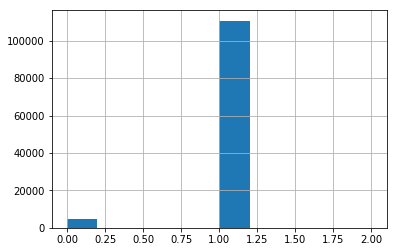

In [81]:
#possibilità di plottare histogrammi
col_name = 'Assegnato'
df_numeric[col_name].hist()

In [82]:
corr = df_numeric.corr()

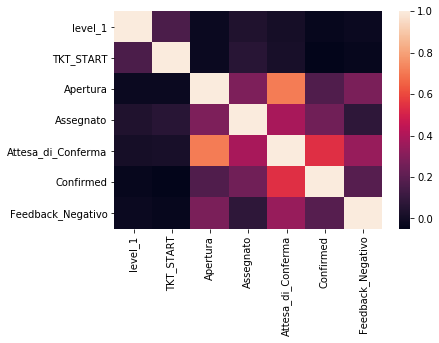

In [85]:
sns.heatmap(corr)

In [85]:
del corr
gc.collect()

0

Explained variance ratio:

[0.34063061 0.16938759 0.1316845  0.12142915 0.11520933 0.09650155
 0.02515727]


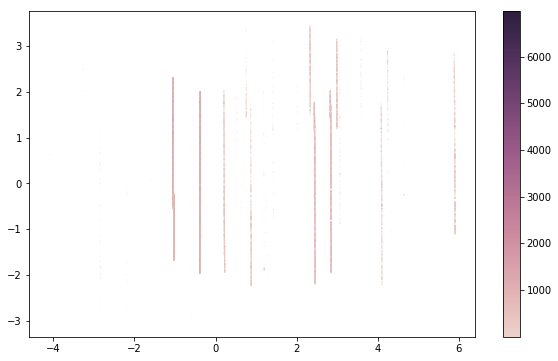

In [ ]:
#mode='regression' for regression task
#mode='classification' for classification task
pca_analysis(df_numeric, target, mode='regression')

In [94]:
del df_numeric
gc.collect()

NameError: name 'df_numeric' is not defined

## Analisi variabili categoriche

## Imputazione missing data

Questa sezione si occupa di imputare i dati, prevede l'imputazione tramite dummy, media, mediana e moda. E' a carico dell'utente, se riesce a scovare migliori relazioni tramite le misure di correlazione e associazione, trovare modi più elaborati di effettuare l'imputazione.

Prevede:

* Report sui missing data tramite la funzione **missing_data_report**.
* ...metodi implementati dall'utente...
* Controllo finale che non vi siano più missing data tramite **isnull**.

In [97]:
missing_data = missing_data_report(df)

In [98]:
missing_data.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Total</th>
      <th>Percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>GRAVITA</th>
      <td>53992</td>
      <td>0.467609</td>
    </tr>
    <tr>
      <th>MARCA</th>
      <td>612</td>
      <td>0.005300</td>
    </tr>
    <tr>
      <th>DINTERV</th>
      <td>322</td>
      <td>0.002789</td>
    </tr>
    <tr>
      <th>Attesa_di_Conferma</th>
      <td>0</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>Attivazione_Specialista</th>
      <td>0</td>
      <td>0.000000</td>
    </tr>
  </tbody>
</table>
</div>

In [99]:
del missing_data
gc.collect()

28

**Parte ad hoc**

La colonna quasi del tutto mancante viene trattata aggiungendo un valore specifico per i missing data poiché è categorica. Quelle con solo qualche occasionale missing data vengono imputate in moda poiché sono categoriche.

In [100]:
df['GRAVITA'] = df['GRAVITA'].astype('object').fillna('_missing').astype('category')

In [101]:
#Imputer di sklearn ha problemi con le categoriche, definiamo una funzione ad hoc
def most_frequent_imputation(df, columns):
    for name in columns:
        col = df[name]
        
        most_frequent = col.value_counts().idxmax()
        
        df[name] = col.fillna(most_frequent)  

In [102]:
most_frequent_imputation(df, ['MARCA', 'DINTERV'])

**Fine parte ad Hoc**

In [103]:
df.isnull().sum().sum()

0

## Analisi del target

In questa sezione ci occupiamo del target. Se il target è categorico puntiamo a scoprire la frequenza di ogni classe, in modo tale, da poter stabilire dei pesi adeguati in caso di classi sbilanciate. Se il target è continuo ci occupiamo di controllarne i quantili e ripulirlo dagli outliayer.

Questa sezione assume che vi sia una pd.Series referenziata da **target** e che abbia un index compatibile con **df** tale da essere univoco per le operazioni di rimozione degli outliayer.

Prevede:
* Calcolare la frequenza di ogni classe se il target è categorico.
* Mostrare i quantili se il target è numerico.

In [104]:
######### Target categorico ##############

#target.value_counts(normalize=True)

In [105]:
######## Target numerico ################
with pd.option_context('display.max_rows', 20):
    display(target.describe(np.arange(.1,1,.1)))

count    80825.000000
mean       317.743638
std        525.566610
min          0.010000
10%          3.180000
20%         22.338000
30.0%       48.790000
40%         96.816000
50%        148.760000
60%        198.684000
70%        307.636000
80%        455.834000
90%        807.956000
max       6981.870000
Name: TARGET, dtype: float64

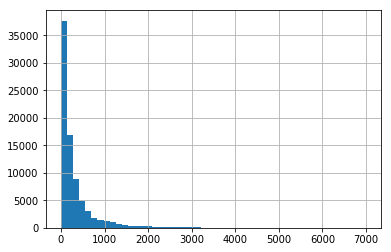

In [108]:
target.hist(bins=50)

## Scissione dei dataset

In questa sezione dividiamo i dataset di train e test preprocessati. Si assume che l'index sia compatibile per joinare la colonna target al train e per fare la submission del test.

Prevede:
* Trasformare le variabili in categoriche se si prevede di utilizzare un metodo che ne abbisogna, escludere questa parte altrimenti.
* Dividere i dataset.

In [109]:
cat_features = df.select_dtypes(include='category').columns.values.tolist()
cat_features

['MERCATO',
 'DEA',
 'COD_PR',
 'MCALL',
 'TKT_TYPE',
 'GRAVITA',
 'DINTERV',
 'MARCA',
 'MODELLO',
 'VERSIONE',
 'SERIE',
 'AVARROLE',
 'AVARUSER',
 'Attesa_Ricambi',
 'Attivazione_Specialista',
 'Caso_Riaperto',
 'Caso_Singolo',
 'Cet',
 'Escalation',
 'Prima_Attivazione_Secondo_Livello',
 'Riapertura',
 'Secondo_Livello_in_Uscita',
 'Soluzione_Non_Efficace']

In [110]:
df[cat_features] = df[cat_features].transform(lambda col: col.cat.codes)

In [111]:
df_train = df[~df['_test']]
df_test = df[df['_test']]

In [112]:
df_train = df_train.drop(columns='_test')
df_test = df_test.drop(columns='_test')

In [113]:
df_train = df_train.join(target)

In [114]:
del df
gc.collect()

227

# Modello e submission

In questa parte ci occuperemo di trainare il modello, effettuare la crossvalidation e creare il file di submission. Inoltre terremo traccia delle prestazioni e della configurazione del modello tramite una scheda tecnica. E' importante, tramite **model_name**, definire un nome univoco per il modello che sarà dato come prefisso a tutti i file che andremo a salvare.

In [115]:
model_name = 'rf'

## SkLearn RandomForest con GridSearchCV

In questa sezione useremo come modello la **RandomForest** di **sk-learn** e come metodo di crossvalidation la **GridSearchCV**.

In [117]:
from  sklearn.ensemble import RandomForestRegressor

## Preparazione dei dati

In questa sezione andremo a trasformare in valori numerici le categoriche.

Prevede:
* Dividere i predittori e il target.

In [118]:
X = df_train.drop(columns='TARGET')
y = df_train['TARGET']

# Validation e ottimizzazione gridsearch

Effettuaiamo la crossvalidation tramite una ricerca easuastiva con **GridSearchCV**. Il template di defoult prevede di fissare 'boosting_type', il tipo di modello, e 'objective' la loss function ma si può anche scegliere di effettuare su di essi la crossvalidation. Si consiglia di farlo in un secondo momento.

Prevede:

* Sciegliere i parametri fissati tramite **params**.
* Sciegliere lo spazio dei parametri in cui effettuare la ricerca tramite **parameter_space**.
* Specificare il numero di folds tramite **n_folds** e la metrica tramite **scorer**.
* Lanciare la **GridSearchCV** cronometrandola e fornendo al metodo **fit** i nomi delle variabili categoriche. L'oggetto **GridSearchCV**, tramite il parametro **refit=True** di default addestra un modello sul training set completo con la miglior configurazione trovata. 
* Mostrare i migliori risultati della gridsearch sottoforma di tidy **pd.DataFrame**.
* Creare una submission tramite la funzione definita dell'utente **make_submission**.

**NOTA**: documentazione dell'API sklearn lgbm http://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html

In [119]:
# per classification consigliato: StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, ShuffleSplit 
from sklearn.metrics import make_scorer

In [120]:
#specificare i parametri che si vuole tenere fissati
params = {'n_jobs': -1
         }

In [121]:
#inserire i parametri sui quali si vuole effettuare la ricerca
parameter_space = {
    'n_estimators': [50,100,150]
    }

In [122]:
mdl = RandomForestRegressor(**params)

In [123]:
# Metodo per creare i diversi folds della cross-validation, di base scegliamo
# un solo fold per problemi di tempo
# per classification consigliato: StratifiedShuffleSplit
n_splits=1
test_size = 0.2

cv = ShuffleSplit(n_splits=n_splits, test_size=test_size)

In [124]:
#tramite scorer è possibile definire una propria funzione di scoring
def _mae(y, y_pred):
    return np.mean(np.abs(y-y_pred))

scorer = make_scorer(score_func=_mae, greater_is_better=False)

In [125]:
grid = GridSearchCV(mdl, parameter_space, verbose=2, scoring=scorer, cv=cv, refit=True)

In [128]:
start_time = time.time()

#grazie al parametro verbose printa i la configurazione che sta provando: 
#si muove iterando i parametri ordinati in ordine alfabetico in modo ricorsivo.
#Così a occhio è possibile capire a che punto è.

grid.fit(X, y)

duration = time.time() - start_time
print('\nTraining time: {} seconds'.format(duration))

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] n_estimators=50 .................................................


[CV] .................................. n_estimators=50, total=  11.0s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV] ................................. n_estimators=100, total=  22.7s
[CV] n_estimators=150 ................................................


[CV] ................................. n_estimators=150, total=  30.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


In [ ]:
grid.best_score_ 

-199.91960450355626

In [93]:
grid.best_params_

{'n_estimators': 150}

In [94]:
pd.set_option('max_columns', 31, 'max_rows', 10)

In [95]:
scores = grid_scores_to_df(grid.grid_scores_).sort_values(by='score', ascending=False)
scores.head()

C:\Users\giova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


fold  n_estimators       score
2     0           150 -199.919605
1     0           100 -201.305358
0     0            50 -201.503058

In [96]:
best_model = grid.best_estimator_
best_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [97]:
#per classification ricordarsi di fare predict_proba se si vogliono le probabilità
y_pred = best_model.predict(df_test)

In [98]:
#salva in model_name_submmission.txt
make_submission(y_pred, df_test.index, model_name)